In [1]:
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip && unzip v2_Annotations_Train_mscoco && \
wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip && unzip v2_Questions_Train_mscoco

--2024-04-12 11:54:32--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.222.40, 52.217.123.248, 54.231.164.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.222.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘v2_Annotations_Train_mscoco.zip’

v2_Annotations_Trai 100%[===================>]  20.70M  55.6MB/s    in 0.4s    

2024-04-12 11:54:33 (55.6 MB/s) - ‘v2_Annotations_Train_mscoco.zip’ saved [21708861/21708861]

Archive:  v2_Annotations_Train_mscoco.zip
  inflating: v2_mscoco_train2014_annotations.json  
--2024-04-12 11:54:35--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.231.64, 54.231.164.216, 52.217.73.246, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.231.64|:443... connected.
HTTP request sent, awaiting

In [2]:
!pip install transformers

In [3]:
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import json
import copy
import glob
import torch
import random
import operator
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from google.colab import files
from numpy.random import choice
from sklearn.manifold import TSNE
from collections import Counter, defaultdict
import pandas as pd
import csv
from torch.utils.data import Dataset
from torchvision.transforms import *
from tqdm.notebook import tqdm
import pickle
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models

In [4]:
annotations = json.load(open("v2_mscoco_train2014_annotations.json"))
questions = json.load(open("v2_OpenEnded_mscoco_train2014_questions.json"))

In [5]:
annotations.keys()

dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])

In [6]:
annotations['annotations'][0]

{'question_type': 'what is this',
 'multiple_choice_answer': 'net',
 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 458752,
 'answer_type': 'other',
 'question_id': 458752000}

In [7]:
questions.keys()

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])

In [8]:
questions['questions']

[{'image_id': 458752,
  'question': 'What is this photo taken looking through?',
  'question_id': 458752000},
 {'image_id': 458752,
  'question': 'What position is this man playing?',
  'question_id': 458752001},
 {'image_id': 458752,
  'question': 'What color is the players shirt?',
  'question_id': 458752002},
 {'image_id': 458752,
  'question': 'Is this man a professional baseball player?',
  'question_id': 458752003},
 {'image_id': 262146,
  'question': 'What color is the snow?',
  'question_id': 262146000},
 {'image_id': 262146,
  'question': 'What is the person doing?',
  'question_id': 262146001},
 {'image_id': 262146,
  'question': 'What color is the persons headwear?',
  'question_id': 262146002},
 {'image_id': 524291,
  'question': "What is in the person's hand?",
  'question_id': 524291000},
 {'image_id': 524291,
  'question': 'Is the dog waiting?',
  'question_id': 524291001},
 {'image_id': 524291,
  'question': 'Is the dog looking at a tennis ball or frisbee?',
  'question

In [9]:
questionid2question = {item['question_id']: item['question'] for item in questions['questions']}

In [10]:
questionid2question

{458752000: 'What is this photo taken looking through?',
 458752001: 'What position is this man playing?',
 458752002: 'What color is the players shirt?',
 458752003: 'Is this man a professional baseball player?',
 262146000: 'What color is the snow?',
 262146001: 'What is the person doing?',
 262146002: 'What color is the persons headwear?',
 524291000: "What is in the person's hand?",
 524291001: 'Is the dog waiting?',
 524291002: 'Is the dog looking at a tennis ball or frisbee?',
 393221000: 'Is the sky blue?',
 393221001: 'Is there snow on the mountains?',
 393221002: 'What is the white streak?',
 393223000: 'Is the window open?',
 393223001: 'What color is the toothbrush?',
 393223002: 'What is the child doing?',
 393223003: 'Is she brushing?',
 393224000: 'Is the man smiling?',
 393224001: 'What is the business man doing in the picture?',
 393224002: 'Does his tie pair well with his suit?',
 393224003: 'Does the man look happy?',
 393224004: 'Is this photo in color?',
 393224005:

In [11]:
annotations['annotations'][0]

{'question_type': 'what is this',
 'multiple_choice_answer': 'net',
 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 458752,
 'answer_type': 'other',
 'question_id': 458752000}

In [12]:
def get_most_probable_answers(answers):
    answers_count = dict()
    for answer in answers:
        answers_count[answer['answer']] = answers_count.get(answer['answer'], 0) + 1
    max_answer = max(answers_count, key = answers_count.get)
    return max_answer

In [13]:
def build_dataset(questions, annotations):
    questionid2question = {item['question_id']: item['question'] for item in questions['questions']}
    questions = questions['questions'] # image_id, question, question_id
    annotations = annotations['annotations'] # image_id, question_id, answers
    question = [questionid2question[item['question_id']] for item in annotations]
    image_id = [item['image_id'] for item in annotations]
    answer = [get_most_probable_answers(item['answers']) for item in annotations]
    df = pd.DataFrame(list(zip(image_id, question, answer)), columns =['image_id', 'question', 'answer'])
    return df


In [14]:
df = build_dataset(questions, annotations)

In [15]:
df.head()

,image_id,question,answer
0,458752,What is this photo taken looking through?,net
1,458752,What position is this man playing?,pitcher
2,458752,What color is the players shirt?,orange
3,458752,Is this man a professional baseball player?,yes
4,262146,What color is the snow?,white


In [16]:
all_possible_answers = df['answer'].unique()
len(all_possible_answers)

22706

In [38]:
threshold_instance_per_class = 1000
threshold_num_classes = 20
sample_size = 1000

def choose_classes_strategy(filterd_answers_freq, threshold_num_classes=None, strategy=None):
    strategy = strategy.lower()
    assert strategy in ['max', 'min', 'random', None]

    if strategy is None:
        # choose all classes
        chosen_classes = filterd_answers_freq.keys()
    elif strategy == 'min':
        # choose classes which have minimum number of frequencies
        assert(threshold_num_classes is not None)
        chosen_classes = sorted(filterd_answers_freq, key=lambda x:filterd_answers_freq[x])[0:threshold_num_classes]
    elif strategy == 'max':
        # choose classes which have maximum number of frequencies
        assert(threshold_num_classes is not None)
        chosen_classes = sorted(filterd_answers_freq, key=lambda x:filterd_answers_freq[x], reverse=True)[0:threshold_num_classes]
    elif strategy == 'random':
        # choose classes randomly
        assert(threshold_num_classes is not None)
        chosen_classes = random.sample(list(filterd_answers_freq.keys()), threshold_num_classes)

    return chosen_classes


def filter_dataframe(df, chosen_classes, sample_size):
    sampled_rows = []
    # TODO 1: sampling from chosen classes
    for class_name in chosen_classes:
        class_rows = df[df['answer'] == class_name]  # Filter rows by the current class
        if len(class_rows) > sample_size:
            sampled_rows.append(class_rows.sample(sample_size))  # If there are more rows than the sample size, sample randomly
        else:
            sampled_rows.append(class_rows)  # If there are fewer rows than the sample size, include all rows

    return pd.concat(sampled_rows)



def get_final_df(df, threshold_instance_per_class=None, threshold_num_classes=None, sample_size=None):
    ans_freq = df['answer'].value_counts()
    filterd_answers_freq = ans_freq[ans_freq > threshold_instance_per_class]
    chosen_classes = choose_classes_strategy(filterd_answers_freq, threshold_num_classes, strategy='random')
    filtered_df = filter_dataframe(df, chosen_classes, sample_size)
    return filtered_df



In [39]:
new_df = get_final_df(df, threshold_instance_per_class, threshold_num_classes, sample_size)

In [40]:
new_df

,image_id,question,answer
562,262299,What color are the stakes in the dirt?,yellow
247403,463792,What color is the man's hat?,yellow
64773,280469,What color is the fire hydrant?,yellow
22335,268512,What color is the van?,yellow
164990,51453,What color is the rim of the plate?,yellow
...,...,...,...
278640,211221,What does one player hold in his hand that the...,baseball
190441,314791,What type of hat is the man wearing?,baseball
34351,271906,What sport are they playing?,baseball
159311,569301,What sport is being played?,baseball


In [41]:
new_df.to_csv("new_df.csv")

In [42]:
new_df = pd.read_csv("new_df.csv", index_col = 0)

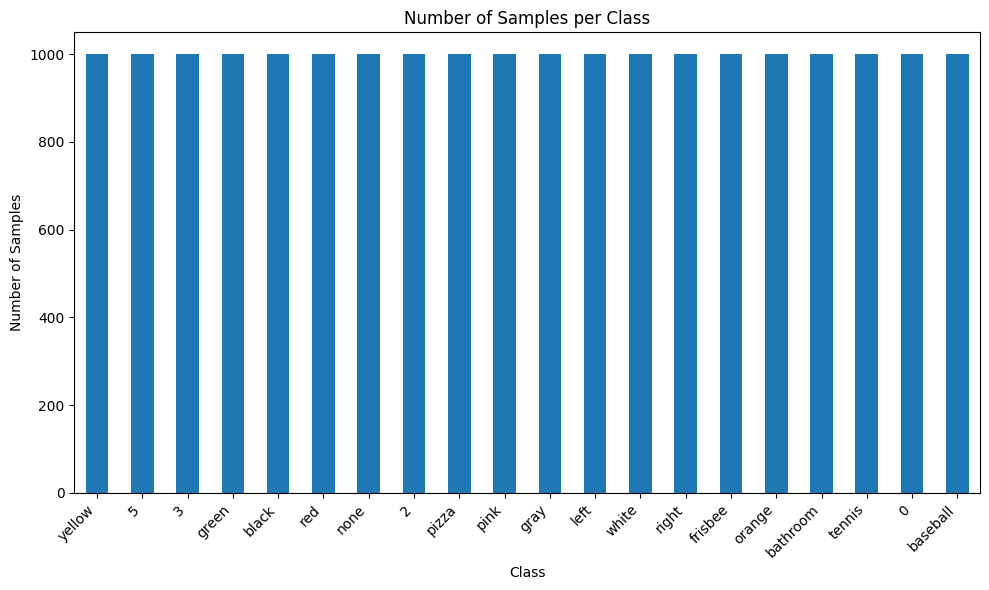

Number of Classes: 20
Classes: ['yellow', '5', '3', 'green', 'black', 'red', 'none', '2', 'pizza', 'pink', 'gray', 'left', 'white', 'right', 'frisbee', 'orange', 'bathroom', 'tennis', '0', 'baseball']


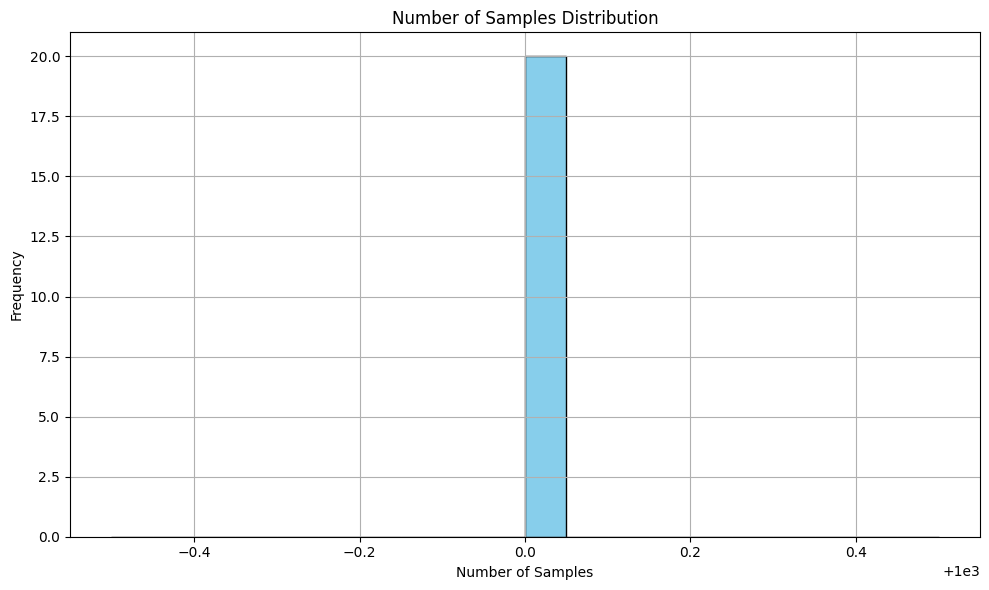

In [43]:
# TODO 2: make a report from dataset
# plot
# number of classes and which classes
def plot_classes_distribution(df):
    class_counts = df['answer'].value_counts()
    num_classes = len(class_counts)

    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Number of Samples per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("Number of Classes:", num_classes)
    print("Classes:", class_counts.index.tolist())
# number of samples from each class
def plot_samples_per_class(df):
    class_counts = df['answer'].value_counts()

    plt.figure(figsize=(10, 6))
    plt.hist(class_counts, bins=20, color='skyblue', edgecolor='black')
    plt.title('Number of Samples Distribution')
    plt.xlabel('Number of Samples')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_classes_distribution(new_df)
plot_samples_per_class(new_df)


In [23]:
def train_val_test_split(df, train_portion = 0.9, val_portion = 0.05, test_portion = 0.05):
    df_train, df_val, df_test, _ = np.split(df.sample(frac=1, random_state=42), [int(train_portion * len(df)), int((train_portion + val_portion) * len(df)), int((train_portion + val_portion + test_portion) * len(df))])
    # TODO 3: Reset train, val , test dataframe index
    df_train.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    return df_train, df_val, df_test


In [24]:
df_train, df_val, df_test = train_val_test_split(new_df)
max_question_len = max(new_df['question'].apply(lambda x: len(x)))
MAX_LEN = 100

In [25]:
len(new_df), len(df_train), len(df_val), len(df_test)

(20000, 18000, 1000, 1000)

In [26]:
max_question_len

95

In [27]:
def get_tokenizer_output(tokenizer, text, attr):
    return np.array(tokenizer(text, padding='max_length', max_length = MAX_LEN, truncation=True, return_tensors="pt")[attr])

In [28]:
train_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

val_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

test_transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
        ])

class SimpleVQADataset(Dataset):
    def __init__(self, df, tokenizer, classes, transform):
        super(SimpleVQADataset, self).__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.labels = []
        self.label2idx = {c:i for i, c in enumerate(classes)}
        self.idx2label = {i:c for i, c in enumerate(classes)}
        self.mapping = self.cunstruct_mapping_dict()
        self.encodings = {}
        self.encodings['input_ids']=[]
        self.encodings['attention_mask']=[]
        self.transform = transform

        for index, row in df.iterrows():
            self.encodings['input_ids'].append(get_tokenizer_output(self.tokenizer, row['question'], 'input_ids'))
            self.encodings['attention_mask'].append(get_tokenizer_output(self.tokenizer, row['question'], 'attention_mask'))
            self.labels.append(self.label2idx[self.mapping[row['answer'].lower()]])
        self.encodings['input_ids'] = np.array(self.encodings['input_ids'])
        self.encodings['attention_mask'] = np.array(self.encodings['attention_mask'])

        self.img_ids = df['image_id']
        self.labels = np.array(self.labels).reshape(-1, 1)


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        image_id = self.img_ids[idx]
        item['image_id'] = image_id
        filename = 'COCO_train2014_'+ str(image_id).zfill(12) + '.jpg'
        trg = os.path.join('./images', filename)
        img = self.transform(Image.open(trg).convert('RGB'))
        item['image'] = img

        return item

    def cunstruct_mapping_dict(self, ):
        map_dict = {}
        for item in self.idx2label.values():
            map_dict[item.lower()] = item
        return map_dict



In [29]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [30]:
classes = new_df['answer'].unique()
classes

array(['2', 'pink', 'gray', 'yellow', 'none', 'blue', 'white', 'black',
       'pizza', '3', 'yes', 'right', 'orange', 'wood', 'brown', 'red',
       'kitchen', '5', 'bathroom', 'frisbee'], dtype=object)

In [31]:
train_dataset = SimpleVQADataset(df_train, tokenizer, classes, train_transform)
val_dataset = SimpleVQADataset(df_val, tokenizer, classes, val_transform)
test_dataset = SimpleVQADataset(df_test, tokenizer, classes, test_transform)

print("ٔNumber of samples in train split", len(train_dataset))
print("Number of samples in val split", len(val_dataset))
print("Number of samples in test split", len(test_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


ٔNumber of samples in train split 18000
Number of samples in val split 1000
Number of samples in test split 1000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [32]:
import os
import urllib.request
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt

target_folder = './'
subfolder_name = 'images'
subfolder_path = os.path.join(target_folder, subfolder_name)

if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

unique_image_ids = new_df['image_id'].unique()

def download_image(img_id):
    filename = 'COCO_train2014_'+ str(img_id).zfill(12) + '.jpg'
    src = os.path.join('https://vqa_mscoco_images.s3.amazonaws.com/train2014/', filename)
    trg = os.path.join(subfolder_path, filename)
    if not os.path.exists(trg):
        urllib.request.urlretrieve(src, trg)

# Using ThreadPoolExecutor to concurrently download images
with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(download_image, unique_image_ids), total=len(unique_image_ids)))


100%|██████████| 16255/16255 [10:20<00:00, 26.19it/s]


# VQA Model

In [33]:
# Step 3: Define the VQA model
class VQAModel(nn.Module):
    def __init__(self, image_feature_extractor, question_feature_extractor, hidden_dim, num_classes):
        super(VQAModel, self).__init__()
        # Image feature extractor (e.g., ResNet50)
        self.image_feature_extractor = image_feature_extractor

        # Question feature extractor (e.g., LSTM)
        self.question_feature_extractor = question_feature_extractor

        # Combined image and question classifier
        self.classifier = nn.Sequential(
            # Define the layers that combine image and question features
            # TODO 5: Linear(hidden_dim, hidden_dim), Dropout 0.2, ReLU, Linear
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)

        )

    def forward(self, image, input_ids, attention_mask):
        # Process the image through the image_features
        image_embedding = self.image_feature_extractor(image).squeeze((2, 3))

        # Process the question through the question_features
        question_embedding = self.question_feature_extractor(input_ids=input_ids,attention_mask=attention_mask).last_hidden_state.mean(dim=1)

        # Combine the image and question features
        # TODO 6: concatenate image embedding and question embedding
        combined_embedding = torch.cat((image_embedding, question_embedding), dim=1)

        # Make a prediction using the classifier
        output = self.classifier(combined_embedding)
        return output

In [34]:
# Step 4: Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for train_batch in tqdm(train_loader):
            images = train_batch['image'].squeeze(1).to(device)
            input_ids = train_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = train_batch['attention_mask'].squeeze(1).to(device)
            train_label = train_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Compute the loss
            loss = criterion(outputs, train_label)

            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (preds == train_label).sum().item()
            total_samples += train_label.size(0)

            # Clear the gradients
            optimizer.zero_grad()

        # Print the loss for this epoch
        print(f"Train, Epoch {epoch + 1} : Loss = {total_loss / len(train_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")

# Step 5: Evaluate the model
def evaluate_model(model, val_loader, criterion, optimizer):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for val_batch in tqdm(val_loader):
            images = val_batch['image'].squeeze(1).to(device)
            input_ids = val_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = val_batch['attention_mask'].squeeze(1).to(device)
            val_label = val_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)

            # Get the predicted answers
            _, preds = torch.max(outputs, dim=1)

            # Update total and correct predictions
            total_correct += (preds == val_label).sum().item()
            total_samples += val_label.size(0)

    print(f"Evaluation : Accuracy = {total_correct / total_samples:.4f}")

In [35]:
classes

array(['2', 'pink', 'gray', 'yellow', 'none', 'blue', 'white', 'black',
       'pizza', '3', 'yes', 'right', 'orange', 'wood', 'brown', 'red',
       'kitchen', '5', 'bathroom', 'frisbee'], dtype=object)

In [44]:
if __name__ == "__main__":
    # Set device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    hidden_dim = 512 + 768    # Replace with the desired hidden dimension

    # TODO 7: load resnet18 pretrained
    model_ft = models.resnet18(pretrained=True)

    # TODO 8: use all layers except the last one which is for classification
    image_feature_extractor = nn.Sequential(*list(model_ft.children())[:-1])


    question_feature_extractor = DistilBertModel.from_pretrained('distilbert-base-uncased')
    num_classes = len(classes)

    model = VQAModel(image_feature_extractor, question_feature_extractor, hidden_dim, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for train_batch in tqdm(train_dataloader):
            images = train_batch['image'].squeeze(1).to(device)
            input_ids = train_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = train_batch['attention_mask'].squeeze(1).to(device)
            train_label = train_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Compute the loss
            loss = criterion(outputs, train_label)

            # Backpropagation
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (preds == train_label).sum().item()
            total_samples += train_label.size(0)

            # Clear the gradients
            optimizer.zero_grad()
        print(f"Train, Epoch {epoch + 1} : Loss = {total_loss / len(train_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")


        model.eval()
        correct = 0
        total = 0
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        # with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            images = val_batch['image'].squeeze(1).to(device)
            input_ids = val_batch['input_ids'].squeeze(1).to(device).to(device)
            attention_mask = val_batch['attention_mask'].squeeze(1).to(device)
            val_label = val_batch['labels'].squeeze(1).to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)

            # Get the predicted answers
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, val_label)

            # Update total and correct predictions
            total_loss += loss.item()
            total_correct += (preds == val_label).sum().item()
            total_samples += val_label.size(0)

        print(f"Evaluation, Epoch {epoch + 1} : Loss = {total_loss / len(val_dataloader):.4f}, Accuracy = {total_correct / total_samples:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/282 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader ru

Train, Epoch 1 : Loss = 2.6921, Accuracy = 0.2076


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Evaluation, Epoch 1 : Loss = 2.6221, Accuracy = 0.2410


100%|██████████| 282/282 [02:59<00:00,  1.57it/s]


Train, Epoch 2 : Loss = 2.5232, Accuracy = 0.2652


100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Evaluation, Epoch 2 : Loss = 2.5755, Accuracy = 0.2470


100%|██████████| 282/282 [02:58<00:00,  1.58it/s]


Train, Epoch 3 : Loss = 2.4063, Accuracy = 0.3024


100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Evaluation, Epoch 3 : Loss = 2.6236, Accuracy = 0.2200


100%|██████████| 282/282 [02:59<00:00,  1.58it/s]


Train, Epoch 4 : Loss = 2.2979, Accuracy = 0.3319


100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


Evaluation, Epoch 4 : Loss = 2.4891, Accuracy = 0.2770


100%|██████████| 282/282 [02:56<00:00,  1.60it/s]


Train, Epoch 5 : Loss = 2.1834, Accuracy = 0.3628


100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Evaluation, Epoch 5 : Loss = 2.6822, Accuracy = 0.2610


100%|██████████| 282/282 [02:57<00:00,  1.59it/s]


Train, Epoch 6 : Loss = 2.0227, Accuracy = 0.4058


100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


Evaluation, Epoch 6 : Loss = 2.6758, Accuracy = 0.2830


100%|██████████| 282/282 [02:58<00:00,  1.58it/s]


Train, Epoch 7 : Loss = 1.8467, Accuracy = 0.4559


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


Evaluation, Epoch 7 : Loss = 2.8012, Accuracy = 0.2620


100%|██████████| 282/282 [02:57<00:00,  1.59it/s]


Train, Epoch 8 : Loss = 1.6490, Accuracy = 0.5113


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


Evaluation, Epoch 8 : Loss = 3.0084, Accuracy = 0.2520


100%|██████████| 282/282 [02:58<00:00,  1.58it/s]


Train, Epoch 9 : Loss = 1.4635, Accuracy = 0.5712


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


Evaluation, Epoch 9 : Loss = 3.1187, Accuracy = 0.2560


100%|██████████| 282/282 [02:57<00:00,  1.59it/s]


Train, Epoch 10 : Loss = 1.2626, Accuracy = 0.6298


100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Evaluation, Epoch 10 : Loss = 3.1894, Accuracy = 0.2590


In [45]:
evaluate_model(model, test_dataloader, criterion, optimizer)

100%|██████████| 1000/1000 [00:34<00:00, 29.14it/s]

Evaluation : Accuracy = 0.2440
